In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import brewer2mpl

set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors

Using TensorFlow backend.


In [2]:
# load json and create model
json_file = open("FE_GPU_model.json","r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into model
model.load_weights("FE_GPU_weights.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [3]:
img_rows, img_cols = 48, 48

x_public = np.load("x_public.npy")
y_public = np.load("y_public.npy")

x_public = x_public.reshape(x_public.shape[0], img_rows, img_cols, 1)
x_public = x_public.astype("float32")
x_public /= 255

loss, accuracy = model.evaluate(x_public, y_public)
print("public test loss: ", loss)
print("public test accuracy: ", accuracy)

3488/3589 [============================>.] - ETA: 0spublic test loss:  2.58215107443
public test accuracy:  0.582334912265


In [4]:
x_private = np.load("x_private.npy")
y_private = np.load("y_private.npy")

x_private = x_private.reshape(x_private.shape[0], img_rows, img_cols, 1)
x_private = x_private.astype("float32")
x_private /= 255

loss, accuracy = model.evaluate(x_private, y_private)
print("private test loss: ", loss)
print("private test accuracy: ", accuracy)

3584/3589 [============================>.] - ETA: 0sprivate test loss:  2.42005875198
private test accuracy:  0.591251044893


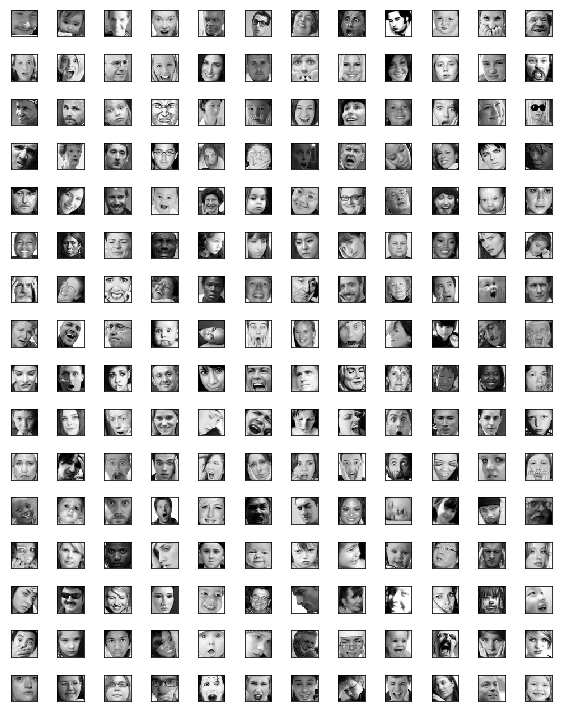

In [5]:
# the following is a data visualization for part of public test datset
def overview(start, end, X):
    fig = plt.figure(figsize=(8,10))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

labels = ["angry", "fear", "happy", "sad", "surprise", "neutral"]
x = np.load("x_public.npy")
y = np.load("y_public.npy")
overview(0, 191, x) # overview of face data as thumbnails (public)

In [6]:
# prediction and true labels
x_public = x.reshape(x.shape[0], img_rows, img_cols, 1)
y_prob = model.predict(x_public, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

In [7]:
# draw the original images
def plot_subjects(start, end, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(12,12))
    emotion = {0:"Angry", 1:"Fear", 2:"Happy", 3:"Sad", 4:"Surprise", 5:"Neutral"}
    for i in range(int(start), int(end+1)):
        input_img = x[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color="#53b3cb", fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color="blue")
        plt.tight_layout()
    plt.show()

In [8]:
# draw the probability bars
def plot_probs(start, end, y_prob):
    fig = plt.figure(figsize=(12,12))
    for i in range(int(start), int(end+1)):
        input_img = x[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.bar(np.arange(0,6), y_prob[i], color=set3, alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ["angry", "fear", "happy", "sad", "surprise", "neutral"]
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [9]:
# the actual prediction is quite different from the test accuracy, since the output is showing a single emotion of 100%
# which is not realistic, rather than a combination of compound emotions
# unfortuantely, I cannot fix this problem, even though the test accuracy seems reasonable
def plot_subjects_with_probs(start, end, y_prob):
    iter = (end - start)/6
    for i in np.arange(0, iter):
        plot_subjects(i*6, (i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6, (i+1)*6-1, y_prob)

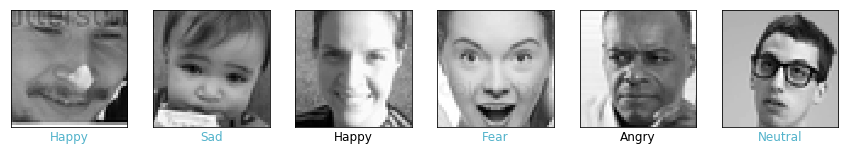

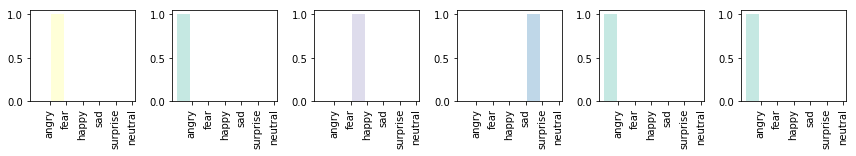

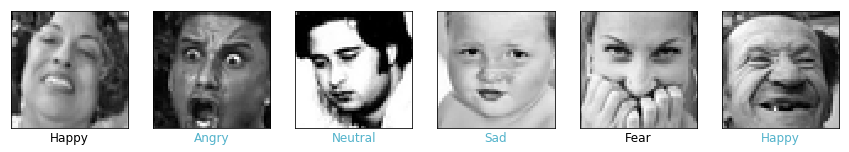

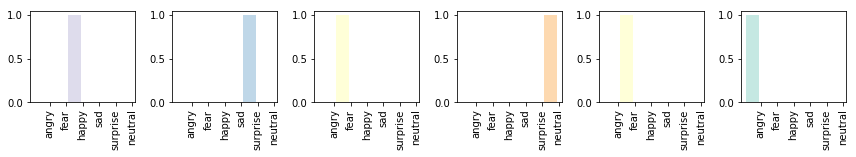

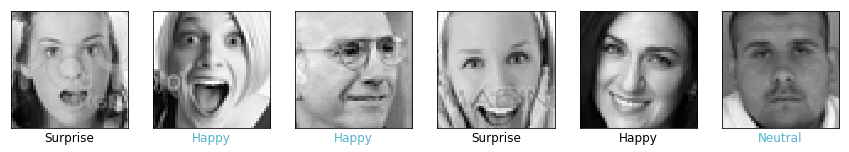

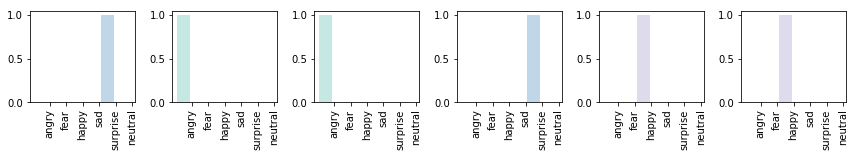

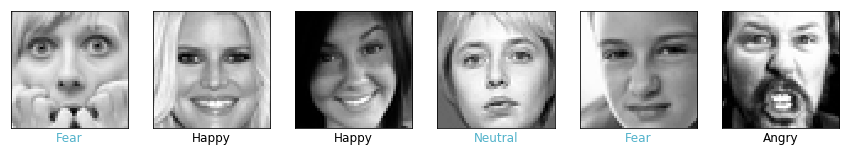

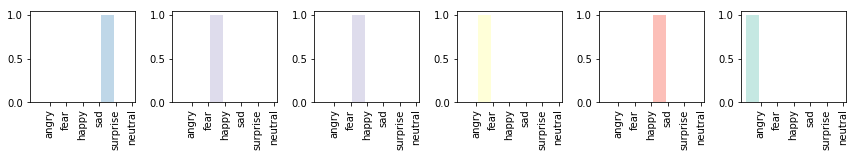

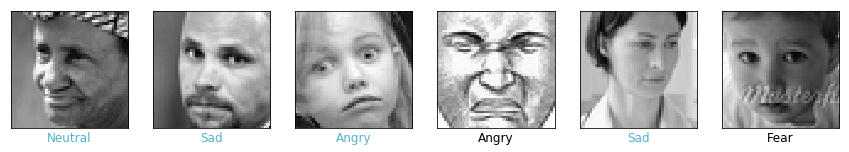

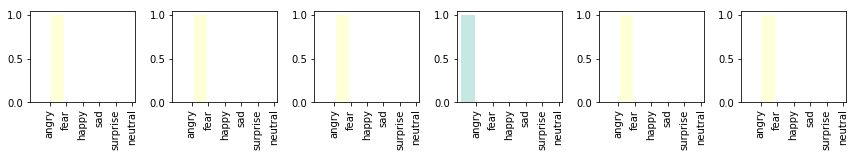

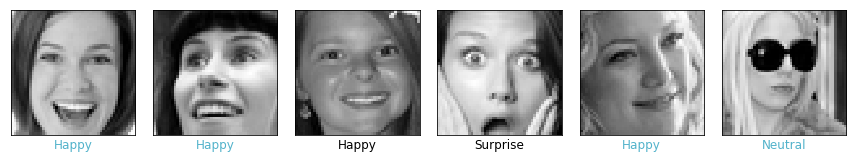

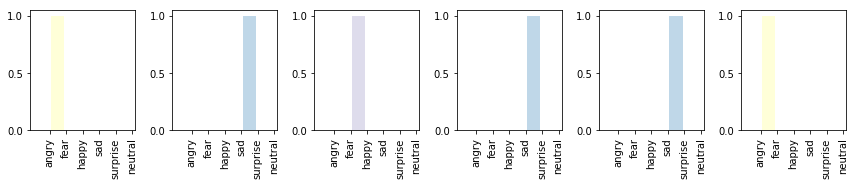

In [10]:
plot_subjects_with_probs(0, 36, y_prob)

In [11]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({"font.size": 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va="center", ha="center")
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [12]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

In [13]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,6)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,6)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [14]:
# public test set
for emotion in labels:
    print(emotion.upper())
    print("   acc = {}".format(class_accuracy(y_true, y_pred, emotion)))
    print("  prec = {}".format(class_precision(y_true, y_pred, emotion)))
    print("recall = {}\n".format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 0.7840624129283923
  prec = 0.30434782608695654
recall = 0.37476099426386233

FEAR
   acc = 0.6857063248815826
  prec = 0.20631970260223048
recall = 0.4475806451612903

HAPPY
   acc = 0.7882418500975202
  prec = 0.6336633663366337
recall = 0.3575418994413408

SAD
   acc = 0.7762607968793536
  prec = 0.29395604395604397
recall = 0.1638591117917305

SURPRISE
   acc = 0.840624129283923
  prec = 0.38672438672438675
recall = 0.6457831325301204

NEUTRAL
   acc = 0.8010587907495124
  prec = 0.3257328990228013
recall = 0.16474464579901152



In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      angry       0.30      0.37      0.34       523
       fear       0.21      0.45      0.28       496
      happy       0.63      0.36      0.46       895
        sad       0.29      0.16      0.21       653
   surprise       0.39      0.65      0.48       415
    neutral       0.33      0.16      0.22       607

avg / total       0.38      0.34      0.33      3589

